# 필요 라이브러리 로드

In [1]:
import pickle
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import warnings

warnings.filterwarnings( 'ignore' )

In [2]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torchvision import models

from torch.utils.data import Dataset, DataLoader

# DEVICE 설정

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')

else:
    DEVICE = torch.device('cpu')

print(f'Using Pytorch version: {torch.__version__}, Device: {DEVICE}')

Using Pytorch version: 1.12.1+cu113, Device: cuda


# Default Model Structure
- Fine-Tuning Model과 동일

## ResNet Structure

In [5]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

## AutoEncoder Structure(224 to 1024)

In [6]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder_cnn = resnet50()

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size = 16, stride = 16, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 128, kernel_size = 8, stride = 8, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 16, kernel_size = 4, stride = 4, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder_cnn(x)
        decoded = self.decoder_conv(encoded)

        return encoded, decoded

## Fine Tuning Classifier(Defualt Model) Structure
- 0: 정상 배추, 1: 비정상 배추

In [7]:
class Classifier(nn.Module):
    def __init__(self, autoEncoder):
        super(Classifier, self).__init__()

        self.encoder_cnn = autoEncoder
        self.fc = nn.Linear(2048, 2)
    
    def forward(self, x):
        encoded, decoded = self.encoder_cnn(x)
        encoded = encoded.view(x.size(0), -1)
        x = self.fc(encoded)
        
        output = F.log_softmax(x)

        return decoded, output

# Dataset Structure

## 사전학습 데이터셋

In [8]:
class Pretrain_Dataset(Dataset):
    def __init__(self, input_image, output_image):
        self.input_image = input_image
        self.output_image = output_image

    def __getitem__(self, i):
        return ((self.input_image[i], ) + (self.output_image[i], ))

    def __len__(self):
        return (len(self.input_image))

## 전이학습 데이터셋

In [9]:
class FineTuning_Dataset(Dataset):
    def __init__(self, input_image, labels):
        self.input_image = input_image
        self.labels = labels

    def __getitem__(self, i):
        return ((self.input_image[i], ) + (self.labels[i], ))

    def __len__(self):
        return (len(self.input_image))

# Default Model(Classifier) 생성

## 초기화 함수

In [10]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

## 모델 생성

In [11]:
pre_train_epochs = 10
EPOCHS = 20
AutoEncoder = AE().to(DEVICE)
model = Classifier(AutoEncoder).to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
pre_train_criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

## Model Structure 확인

In [12]:
print(model)

Classifier(
  (encoder_cnn): AE(
    (encoder_cnn): ResNet(
      (conv1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (conv2_x): Sequential(
        (0): BottleNeck(
          (residual_function): Sequential(
            (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
            (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (7): Batc

# Pre-Train용 Train, validation 함수

## pre-train

In [13]:
def pre_train(model, train_loader_dirs, optimizer):
    model.train()
    train_loss = 0
    all_num = 0

    for i, trainLoaderName in enumerate(train_loader_dirs):
        with open(trainLoaderName, 'rb') as f:
            train_loader = pickle.load(f)

        for batch_idx, (input_image, output_image) in enumerate(train_loader):
            input_image = input_image.to(DEVICE)
            output_image = output_image.to(DEVICE)
            optimizer.zero_grad()
            output, _ = model(input_image)
            loss = pre_train_criterion(output, output_image)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        all_num += len(train_loader.dataset)
        
        if i % 10 == 0:
            print(f'----------------{i}/{len(train_loader_dirs)}----------------')
            print(f'loss: {train_loss/all_num}')

    print('----------------end----------------')
    print(f'loss: {train_loss/all_num}')

    return train_loss/all_num

## pre train 검증

In [14]:
def pre_train_validation(model, valid_loader_dirs):
    model.eval()
    valid_loss = 0
    all_num = 0
    valid_show_point = np.random.randint(len(valid_loader_dirs))
    
    for i, validLoaderName in enumerate(valid_loader_dirs):
        with open(validLoaderName, 'rb') as f:
            valid_loader = pickle.load(f)

        with torch.no_grad():
            for input_image, output_image in valid_loader:
                input_image = input_image.to(DEVICE)
                output_image = output_image.to(DEVICE)
                output, _ = model(input_image)
                valid_loss += pre_train_criterion(output, output_image).item()

        all_num += len(valid_loader.dataset)
        if i == valid_show_point:
            temp_random_point = np.random.randint(len(input_image))
            show_input_image = input_image.detach().cpu().numpy()[temp_random_point].reshape(224, 224, 3)
            show_output_image = output.detach().cpu().numpy()[temp_random_point].reshape(1024, 1024, 3)
            show_true_image = output_image.detach().cpu().numpy()[temp_random_point].reshape(1024, 1024, 3)

    print('----------------Validation----------------')
    print(f'loss: {valid_loss/all_num}')
    fig, ax = plt.subplots(1,3)
    grid = plt.GridSpec(1,3,wspace=0.5, hspace=0.5)
    plt.subplot(grid[0,0]).imshow(show_input_image)
    plt.subplot(grid[0,1]).imshow(show_output_image)
    plt.subplot(grid[0,2]).imshow(show_true_image)
    plt.show()

    return valid_loss/all_num

# Train, Validation, Test Function

## Train Function

In [15]:
def fineTuning_train(model, train_loader_dirs, optimizer):
    model.train()
    outputs = []
    labels = []
    for i, trainLoaderName in enumerate(train_loader_dirs):
        with open(trainLoaderName, 'rb') as f:
            train_loader = pickle.load(f)

        for batch_idx, (image, label) in enumerate(train_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            optimizer.zero_grad()
            _, output = model(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            temp_output = output.detach().cpu().numpy()
            temp_label = label.detach().cpu().numpy()
            outputs += list(temp_output)
            labels += list(temp_label)
        
        if i % 10 == 0:
            print(f'----------------{i}/{len(train_loader_dirs)}----------------')
            y_pred = np.argmax(np.array(outputs), axis=1)
            print(f'Accuracy: {accuracy_score(labels, y_pred)}')
            print(f'F1 Score: {f1_score(labels, y_pred)}')

    print('----------------end----------------')
    outputs = np.array(outputs)
    y_pred = np.argmax(outputs, axis=1)
    print(f'Accuracy: {accuracy_score(labels, y_pred)}')
    print(f'F1 Score: {f1_score(labels, y_pred)}')
    print(f'AUC: {roc_auc_score(labels, outputs[:, 1])}')

    return f1_score(labels, y_pred), roc_auc_score(labels, outputs[:, 1])

## Validation Function

In [16]:
def fineTuning_Validation(model, valid_loader_dirs):
    model.eval()

    outputs = []
    labels = []
    for i, validLoaderName in enumerate(valid_loader_dirs):
        with open(validLoaderName, 'rb') as f:
            valid_loader = pickle.load(f)

        with torch.no_grad():
            for image, label in valid_loader:
                image = image.to(DEVICE)
                label = label.to(DEVICE)
                _, output = model(image)

                temp_output = output.detach().cpu().numpy()
                temp_label = label.detach().cpu().numpy()
                outputs += list(temp_output)
                labels += list(temp_label)
    print('----------------Validation----------------')
    outputs = np.array(outputs)
    y_pred = np.argmax(outputs, axis=1)
    print(f'Accuracy: {accuracy_score(labels, y_pred)}')
    print(f'F1 Score: {f1_score(labels, y_pred)}')
    print(f'AUC: {roc_auc_score(labels, outputs[:, 1])}')

    return f1_score(labels, y_pred), roc_auc_score(labels, outputs[:, 1])

## Test Function

In [17]:
def Test(model, test_loader_dirs):
    model.eval()

    outputs = []
    labels = []
    for i, testLoaderName in enumerate(test_loader_dirs):
        with open(testLoaderName, 'rb') as f:
            test_loader = pickle.load(f)

        with torch.no_grad():
            for image, label in test_loader:
                image = image.to(DEVICE)
                label = label.to(DEVICE)
                _, output = model(image)

                temp_output = output.detach().cpu().numpy()
                temp_label = label.detach().cpu().numpy()
                outputs += list(temp_output)
                labels += list(temp_label)
    print('----------------Test----------------')
    outputs = np.array(outputs)
    y_pred = np.argmax(outputs, axis=1)
    print(f'Accuracy: {accuracy_score(labels, y_pred)}')
    print(f'F1 Score: {f1_score(labels, y_pred)}')
    print(f'AUC: {roc_auc_score(labels, outputs[:, 1])}')

    return f1_score(labels, y_pred), roc_auc_score(labels, outputs[:, 1])

# Pre-Train and Pre-valid

## Train and valid split

In [18]:
normalLoaderPath = '/content/drive/MyDrive/학교 수업 프로젝트/기계학습/02 Preprocessed Dataset/02 배추 질병 여부 탐지용 Dataloader/01 Pre-train dataloader/01 Normal'
abnormalLoaderPath = '/content/drive/MyDrive/학교 수업 프로젝트/기계학습/02 Preprocessed Dataset/02 배추 질병 여부 탐지용 Dataloader/01 Pre-train dataloader/02 Abnormal'

normalLoaderDirs = [normalLoaderPath + '/' + dir for dir in os.listdir(normalLoaderPath)]
abnormalLoaderDirs = [abnormalLoaderPath + '/' + dir for dir in os.listdir(abnormalLoaderPath)]

pretrainLoaderDirs = normalLoaderDirs[:int(len(normalLoaderDirs)*0.8)] + abnormalLoaderDirs[:int(len(abnormalLoaderDirs)*0.8)]
prevalidLoaderDirs = normalLoaderDirs[int(len(normalLoaderDirs)*0.8):] + abnormalLoaderDirs[int(len(abnormalLoaderDirs)*0.8):]

## pre-train

  0%|          | 0/10 [00:00<?, ?it/s]

----------------0/44----------------
loss: 0.043135335901752114
----------------10/44----------------
loss: 0.04192380903458053
----------------20/44----------------
loss: 0.04170534603890614
----------------30/44----------------
loss: 0.041515795272262915
----------------40/44----------------
loss: 0.04137915213672101
----------------end----------------
loss: 0.04130073285345493


----------------Validation----------------
loss: 0.040866473720620654


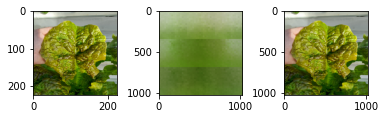

----------------0/44----------------
loss: 0.040301725966855884
----------------10/44----------------
loss: 0.04028563708235315
----------------20/44----------------
loss: 0.04071382069290542
----------------30/44----------------
loss: 0.04062902442128712
----------------40/44----------------
loss: 0.04046020029129818
----------------end----------------
loss: 0.04043665499039988


----------------Validation----------------
loss: 0.04092437551399978


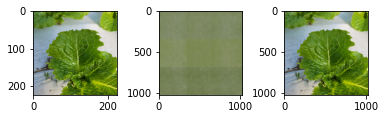

----------------0/44----------------
loss: 0.04118612105958164
----------------10/44----------------
loss: 0.039949181362647905
----------------20/44----------------
loss: 0.03993105202070659
----------------30/44----------------
loss: 0.03982916695155924
----------------40/44----------------
loss: 0.03989024461613338
----------------end----------------
loss: 0.03990568851529183


----------------Validation----------------
loss: 0.03976314442450185


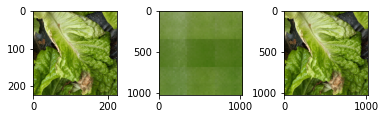

----------------0/44----------------
loss: 0.039192168507725
----------------10/44----------------
loss: 0.03953552472574467
----------------20/44----------------
loss: 0.03954564306574563
----------------30/44----------------
loss: 0.039671267366869274
----------------40/44----------------
loss: 0.03972377935122567
----------------end----------------
loss: 0.03966848311054484


----------------Validation----------------
loss: 0.039447872872148654


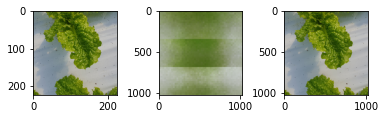

----------------0/44----------------
loss: 0.03868959844112396
----------------10/44----------------
loss: 0.0391099335287105
----------------20/44----------------
loss: 0.03946221603213677
----------------30/44----------------
loss: 0.03946748877605123
----------------40/44----------------
loss: 0.03946031588584003
----------------end----------------
loss: 0.039452955452888856


----------------Validation----------------
loss: 0.03952649698193396


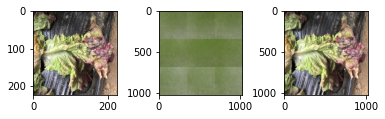

----------------0/44----------------
loss: 0.03892309917137027
----------------10/44----------------
loss: 0.03935073525644839
----------------20/44----------------
loss: 0.03926165788537132
----------------30/44----------------
loss: 0.03914851605700526
----------------40/44----------------
loss: 0.03917327485455945
----------------end----------------
loss: 0.03923925942884183


----------------Validation----------------
loss: 0.039867759319782765


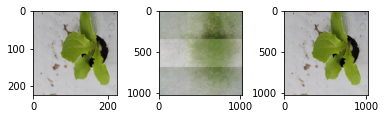

----------------0/44----------------
loss: 0.03910580277442932
----------------10/44----------------
loss: 0.03856354465030811
----------------20/44----------------
loss: 0.03864776912987942
----------------30/44----------------
loss: 0.039042821169019706
----------------40/44----------------
loss: 0.039093595088595175
----------------end----------------
loss: 0.03909462800941134


----------------Validation----------------
loss: 0.03976374017598141


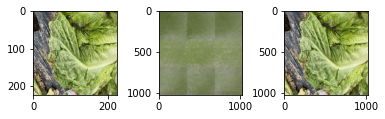

----------------0/44----------------
loss: 0.04049633955582976
----------------10/44----------------
loss: 0.03918991462242874
----------------20/44----------------
loss: 0.03911076008253509
----------------30/44----------------
loss: 0.0391093690338875
----------------40/44----------------
loss: 0.039007077029089336
----------------end----------------
loss: 0.03894854518493897


----------------Validation----------------
loss: 0.03884058577637657


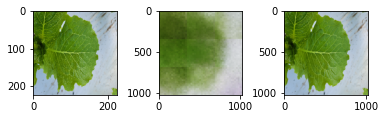

----------------0/44----------------
loss: 0.038008129922673106
----------------10/44----------------
loss: 0.038790750042112035
----------------20/44----------------
loss: 0.03866880629229523
----------------30/44----------------
loss: 0.03867789238595502
----------------40/44----------------
loss: 0.0385667629154281
----------------end----------------
loss: 0.038651661696567585


----------------Validation----------------
loss: 0.03913164770868651


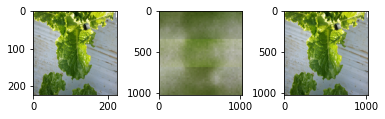

----------------0/44----------------
loss: 0.04047373007051647
----------------10/44----------------
loss: 0.038632426601411265
----------------20/44----------------
loss: 0.03858189175038466
----------------30/44----------------
loss: 0.03859368104260068
----------------40/44----------------
loss: 0.03855166701112442
----------------end----------------
loss: 0.038492467090330454


----------------Validation----------------
loss: 0.03845602225481979


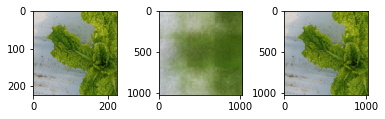

<All keys matched successfully>

In [19]:
best_loss = 1000000.
best_loss_path = '/content/drive/MyDrive/학교 수업 프로젝트/기계학습/01 Code/03 Pre-train and Fine-Tuning Model Test/best_loss_model.p'
train_losses = []
valid_losses = []

for Epoch in tqdm_notebook(range(10)):
    random.shuffle(pretrainLoaderDirs)
    loss = pre_train(model, pretrainLoaderDirs, optimizer)
    train_losses.append(loss)
    loss = pre_train_validation(model, prevalidLoaderDirs)
    valid_losses.append(loss)

    if best_loss > loss:
        torch.save(model.state_dict(), best_loss_path)
        best_loss = loss

model.load_state_dict(torch.load(best_loss_path))

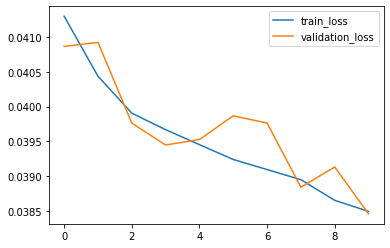

In [20]:
plt.plot(train_losses, label='train_loss')
plt.plot(valid_losses, label='validation_loss')
plt.legend(loc='best')
plt.show()

# Train And Valid

## train and valid split

In [21]:
normalLoaderPath = '/content/drive/MyDrive/학교 수업 프로젝트/기계학습/02 Preprocessed Dataset/02 배추 질병 여부 탐지용 Dataloader/02 Fine-tuning dataloader/01 Normal'
abnormalLoaderPath = '/content/drive/MyDrive/학교 수업 프로젝트/기계학습/02 Preprocessed Dataset/02 배추 질병 여부 탐지용 Dataloader/02 Fine-tuning dataloader/02 Abnormal'

normalLoaderDirs = [normalLoaderPath + '/' + dir for dir in os.listdir(normalLoaderPath)]
abnormalLoaderDirs = [abnormalLoaderPath + '/' + dir for dir in os.listdir(abnormalLoaderPath)]

trainLoaderDirs = normalLoaderDirs[:int(len(normalLoaderDirs)*0.8)] + abnormalLoaderDirs[:int(len(abnormalLoaderDirs)*0.8)]
validLoaderDirs = normalLoaderDirs[int(len(normalLoaderDirs)*0.8):] + abnormalLoaderDirs[int(len(abnormalLoaderDirs)*0.8):]

## Train and Valid

In [22]:
best_f1 = 0
best_auc = 0

best_f1_path = '/content/drive/MyDrive/학교 수업 프로젝트/기계학습/01 Code/03 Pre-train and Fine-Tuning Model Test/best_f1_model1.p'
best_auc_path = '/content/drive/MyDrive/학교 수업 프로젝트/기계학습/01 Code/03 Pre-train and Fine-Tuning Model Test/best_auc_model2.p'

train_f1s = []
train_aucs = []

valid_f1s = []
valid_aucs = []

for Epoch in tqdm_notebook(range(EPOCHS)):
    random.shuffle(trainLoaderDirs)
    f1, auc = fineTuning_train(model, trainLoaderDirs, optimizer)
    train_f1s.append(f1)
    train_aucs.append(auc)
    f1, auc = fineTuning_Validation(model, validLoaderDirs)
    valid_f1s.append(f1)
    valid_aucs.append(auc)
    if f1 > best_f1:
        torch.save(model.state_dict(), best_f1_path)
        best_f1 = f1
    if auc > best_auc:
        torch.save(model.state_dict(), best_auc_path)
        best_auc = auc

  0%|          | 0/20 [00:00<?, ?it/s]

----------------0/44----------------
Accuracy: 0.97265625
F1 Score: 0.0
----------------10/44----------------
Accuracy: 0.95969868173258
F1 Score: 0.0
----------------20/44----------------
Accuracy: 0.8170661553211889
F1 Score: 0.6458797327394209
----------------30/44----------------
Accuracy: 0.7987138263665595
F1 Score: 0.5718194254445964
----------------40/44----------------
Accuracy: 0.7940009675858732
F1 Score: 0.5221099887766554
----------------end----------------
Accuracy: 0.808250022516437
F1 Score: 0.5221099887766554
AUC: 0.7680175936894662
----------------Validation----------------
Accuracy: 0.7285259809119831
F1 Score: 0.0
AUC: 0.5198142841258289
----------------0/44----------------
Accuracy: 1.0
F1 Score: 0.0
----------------10/44----------------
Accuracy: 0.90234375
F1 Score: 0.0
----------------20/44----------------
Accuracy: 0.7585810162991371
F1 Score: 0.312397596941562
----------------30/44----------------
Accuracy: 0.7585852090032155
F1 Score: 0.23356472029399752
----

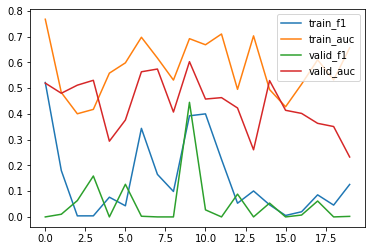

In [23]:
plt.plot(train_f1s, label='train_f1')
plt.plot(train_aucs, label='train_auc')
plt.plot(valid_f1s, label='valid_f1')
plt.plot(valid_aucs, label='valid_auc')
plt.legend(loc='best')
plt.show()

# Test

## Test loader load

In [24]:
testNormalLoaderPath = '/content/drive/MyDrive/학교 수업 프로젝트/기계학습/02 Preprocessed Dataset/02 배추 질병 여부 탐지용 Dataloader/03 Test dataloader/01 Normal'
testAbormalLoaderPath = '/content/drive/MyDrive/학교 수업 프로젝트/기계학습/02 Preprocessed Dataset/02 배추 질병 여부 탐지용 Dataloader/03 Test dataloader/02 Abnormal'

testNormalLoaderDirs = [testNormalLoaderPath + '/' + dir for dir in os.listdir(testNormalLoaderPath)]
testAbnormalLoaderDirs = [testAbormalLoaderPath + '/' + dir for dir in os.listdir(testAbormalLoaderPath)]

testLoaderDirs = testNormalLoaderDirs + testAbnormalLoaderDirs

## Best F1 Model test

In [25]:
model.load_state_dict(torch.load(best_f1_path))
model.eval()
Test(model, testLoaderDirs)

----------------Test----------------
Accuracy: 0.763302752293578
F1 Score: 0.8593238822246456
AUC: 0.6662005965697242


(0.8593238822246456, 0.6662005965697242)

## Best AUC Model test

In [26]:
model.load_state_dict(torch.load(best_auc_path))
model.eval()
Test(model, testLoaderDirs)

----------------Test----------------
Accuracy: 0.763302752293578
F1 Score: 0.8593238822246456
AUC: 0.6662005965697242


(0.8593238822246456, 0.6662005965697242)